# Solução analítica

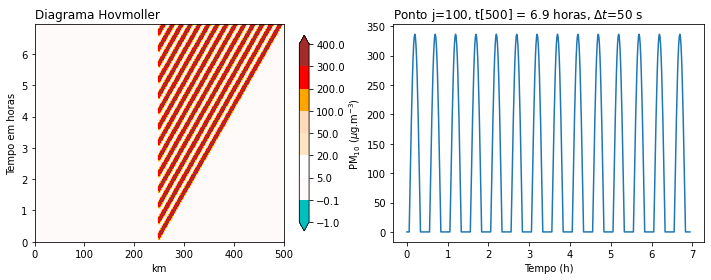

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
from matplotlib import animation, rc
from functions import *
import scipy.sparse as sp

# Condições do exercício
# ----------------------
Nx, dx, Nt, dt, U  = 201, 2500, 501, 50, 10, 
x, _ = np.linspace(0, (Nx-1)*dx, Nx, retstep = True)
t, _ = np.linspace(0, (Nt-1)*dt, Nt, retstep = True)
CFL     = U*dt/dx   
ylabel =  "PM$_{10}$ ($\mu$g.m$^{-3}$)"
C_s = np.zeros((Nx, Nt))
#w = int(dx/(dt*U)-1) # w*dt*U/dx = 1; w*dt = dx
T, X = np.meshgrid(t, x)

levels=[-1,-.1,5,20,50,100,200, 300, 400]
# ----------------------

for n in range(1, Nt):
    om=2*np.pi/1800
    k= om/U
    j = int(100 + U*t[n]/dx)
    C_s[100:j, n] = C_s[100:j, n-1] - \
                    (np.cos(-x[100:j]*k + om*t[n])/om - \
                    np.cos(-x[100:j]*k + om*t[n-1])/om)   

C_s[C_s <= 0] = 0
   
# Figura de solução analítica
hovm(X, T, C_s, ylabel, "fonte", n, dt, t, fonte=True, levels=levels)

# Ordem 1 (avanzado no tempo, atrasado no espaço)


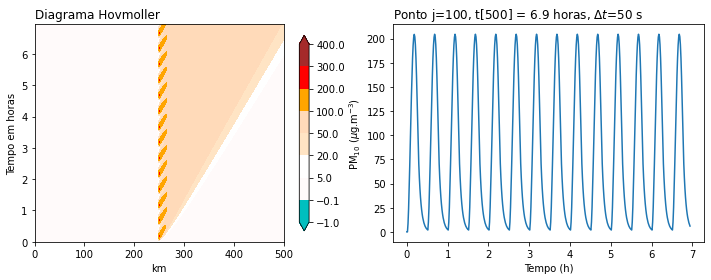

In [12]:
# Condições do exercício
# ----------------------
C = np.zeros((Nx, Nt))
F = C.copy()

for n in range(1, Nt):
    F[100, n-1] = wave(t,n-1)
    # advecção ordem 1
    C = euler_back(C, n, CFL, dt, F)

hovm(X, T, C, ylabel, "ordem1", n, dt, t, fonte=True, levels=levels)

# Leapfrog 2a ordem

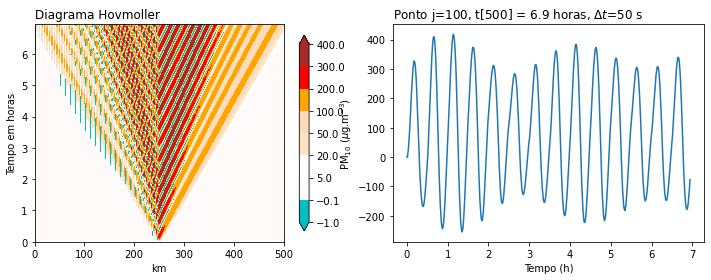

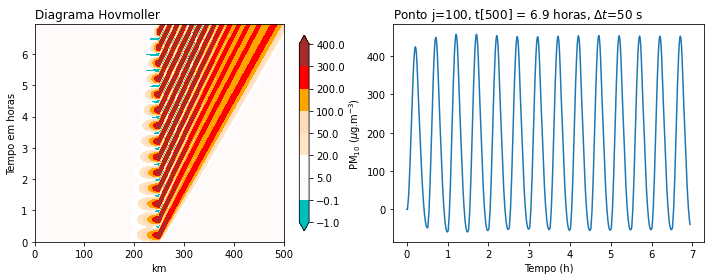

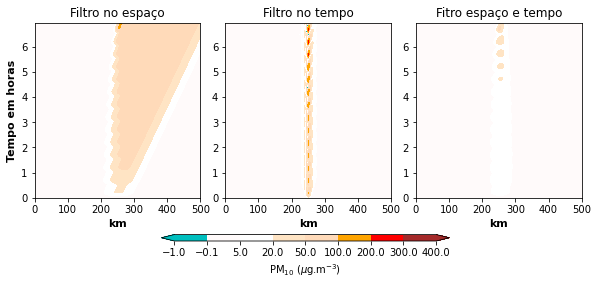

In [15]:
# Condições do exercício
# ----------------------
C_l = np.zeros((Nx, Nt))
C_lf = C_l.copy()
C_lf_all_space = C_l.copy()
C_lf_all_time = C_l.copy()
C_lf_all_both = C_l.copy()
C_lf_all = {'space':C_lf_all_space, 'time':C_lf_all_time, 'both':C_lf_all_both}
F = C_l.copy()
bools = {'space':[True, False], 'time': [False, True], 'both':[True, True]}
names ={'space':'Filtro no espaço', 'time':'Filtro no tempo', 'both':"Fitro espaço e tempo"}
colores = ['c','snow','w','bisque', 'peachpuff','orange', 'red', 'brown']

levels=[-1,-.1,5,20,50,100,200, 300, 400]

for n in range(1, Nt):
    F[100,n-1] = wave(t,n-1)
    C_l = leap2(C_l, n, CFL, dt, F, f_space=False, f_time = False, alfa=0.105)
    
    C_lf = leap2(C_lf, n, CFL, dt, F, f_space=True, f_time=True)
    for k in C_lf_all.keys():
        C_lf_all[k] = leap2(C_lf_all[k], n, CFL, dt, F, f_space=False, f_time=False)
        C_lf_all[k] = filtro_all(C_lf_all[k], alfa=0.105, f_space=bools[k][0], f_time=bools[k][1])       


hovm(X, T, C_l, ylabel, "leapfrog2", n, dt, t, fonte=True, levels=levels)
hovm(X, T, C_lf, ylabel, "leapfrog2-f", n, dt, t, fonte=True, levels=levels)

# ------------------------------------------
fig = plt.figure(figsize=[8,3], facecolor='w')
plt.subplots_adjust(bottom=0.15, top=0.96, left=0.04, right=0.99,
                    wspace=0.15, hspace=0.27) # horizontal & vertical spaces, respectively
nrows, ncols = 1, 3

for i, k in zip(range(1, 4), C_lf_all.keys()): 
    plt.subplot(nrows, ncols, i)
    im = plt.contourf(X/1000, T/3600, C_lf_all[k], levels, origin='lower', extend='both', colors=colores)
    plt.title(names[k])
    
    if i% ncols == 1: # Add ylabel for the very left subplots
        plt.ylabel('Tempo em horas', fontsize=11, fontweight='bold')
    if i > ncols*(nrows-1): # Add xlabel for the bottom row subplots
        plt.xlabel('km', fontsize=11, fontweight='bold')
        
# Add a colorbar at the bottom:
cax = fig.add_axes([0.26, -0.05, 0.5, 0.03])
cb = fig.colorbar(im, cax=cax, orientation="horizontal",shrink=1)
cb.ax.tick_params(labelsize=10)
cb.set_label(label=ylabel, color = 'k', size=10)
fig.savefig("fig/lf_all.png", dpi=400, format='png', bbox_inches='tight', facecolor='w')

# 4a ordem

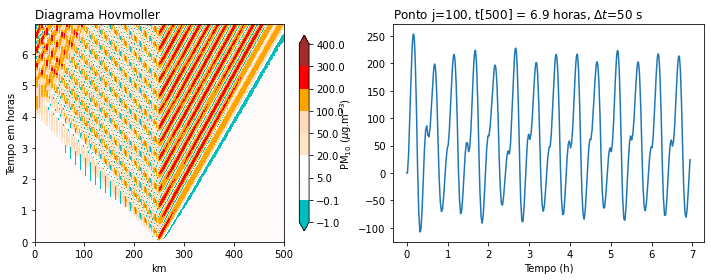

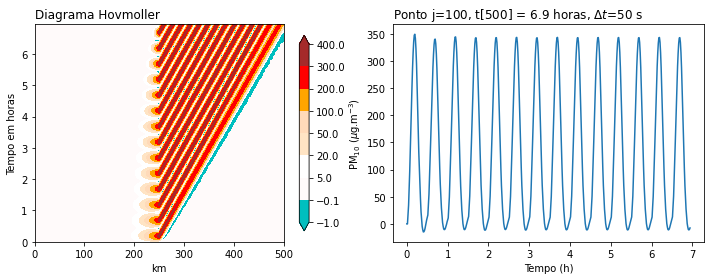

In [23]:
# Condições do exercício
# ----------------------
C_4o = np.zeros((Nx, Nt))
C_4of = C_4o.copy()
F = C_4o.copy()

for n in range(1, Nt):
    F[100,n-1] = wave(t,n-1)
    # Não filtrado
    C_4o = ordem4(C_4o,n, CFL, dt, F)

    # Filtrado
    C_4of = ordem4(C_4of,n, CFL, dt, F, f_space=True, f_time = True)

hovm(X, T, C_4o, ylabel, "ordem4", n, dt, t, fonte=True, levels=levels)
hovm(X, T, C_4of, ylabel, "ordem4-f", n, dt, t, fonte=True, levels=levels)

# Implícito: Crank-Nicolson

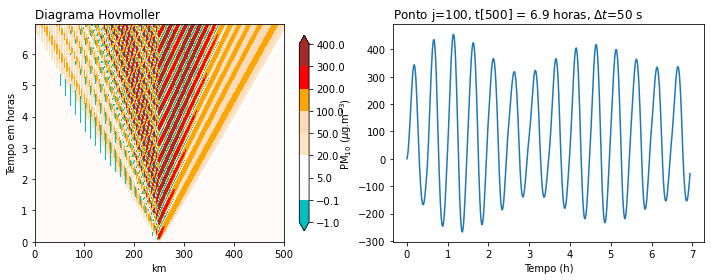

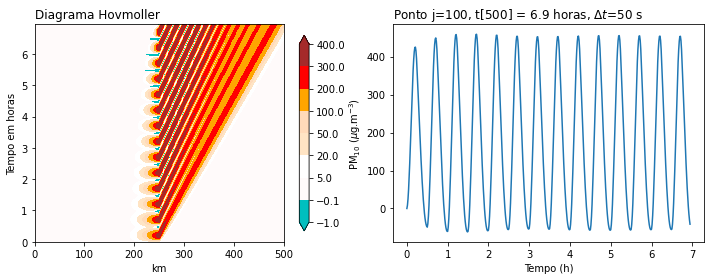

In [30]:
# Condições do exercício
# ----------------------
C_cr = np.zeros((Nx, Nt))
C_crf = C_cr.copy()
F = C_cr.copy()
A, B = crank_matrix(CFL, x)

for n in range(1, Nt):
    F[100,n-1] = wave(t,n-1)*dt
    C_cr[:,n-1] = C_cr[:,n-1] + F[:,n-1]
    C_cr = crank(A, B, C_cr, n, CFL, f_space=False, f_time = False)

    C_crf[:,n-1] = C_crf[:,n-1] + F[:,n-1]
    C_crf = crank(A, B, C_crf, n, CFL, f_space=True, f_time = True)

hovm(X, T, C_cr, ylabel, "CN", n, dt, t, fonte=True, levels=levels)
hovm(X, T, C_crf, ylabel, "CN-f", n, dt, t, fonte=True, levels=levels)

## Figuras
  - [x] (a) Avançado no tempo atrasado no espaço
  - [x] (b) Leapfrog 2ª ordem
  - [x] (c) 4ª ordem no espaço
  - [x] (d) Implícito (e.g., Crank-Nicolson)

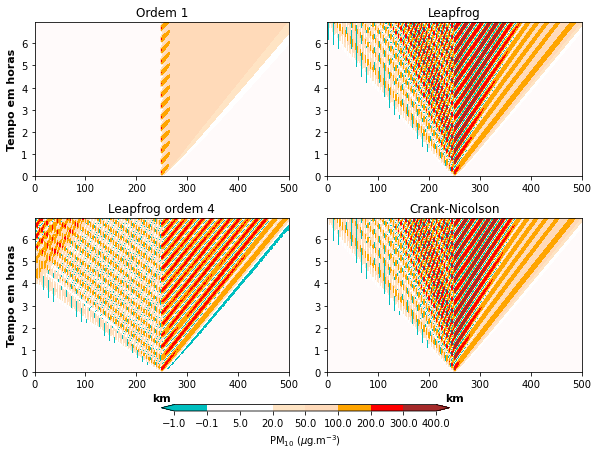

In [31]:
Num = {'Ordem 1': C, 'Leapfrog':C_l, 'Leapfrog ordem 4':C_4o, 'Crank-Nicolson':C_cr}
names = list(Num.keys())
levels=[-1,-.1,5,20,50,100,200, 300, 400]
colores = ['c','snow','w','bisque', 'peachpuff','orange', 'red', 'brown']

fig = plt.figure(figsize=[8,6], facecolor='w')
plt.subplots_adjust(bottom=0.15, top=0.96, left=0.04, right=0.99,
                    wspace=0.15, hspace=0.27) # horizontal & vertical spaces, respectively
nrows, ncols = 2, 2

for i in range(1, 5): 
    plt.subplot(nrows, ncols, i)
    im = plt.contourf(X/1000, T/3600, Num[names[i-1]], levels, origin='lower', extend='both', colors=colores)
    plt.title(names[i-1])
    
    if i% ncols == 1: # Add ylabel for the very left subplots
        plt.ylabel('Tempo em horas', fontsize=11, fontweight='bold')
    if i > ncols*(nrows-1): # Add xlabel for the bottom row subplots
        plt.xlabel('km', fontsize=11, fontweight='bold')
        
# Add a colorbar at the bottom:
cax = fig.add_axes([0.26, 0.06, 0.5, 0.015])
cb = fig.colorbar(im, cax=cax, orientation="horizontal",shrink=1)
cb.ax.tick_params(labelsize=10)
cb.set_label(label=ylabel, color = 'k', size=10)
fig.savefig("fig/sol_num.png", dpi=400, format='png', bbox_inches='tight', facecolor='w')

Com filtro 

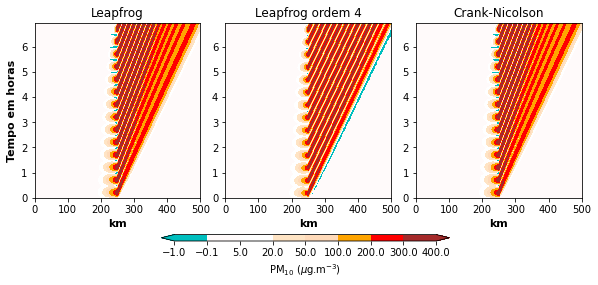

In [32]:
Num = {'Leapfrog':C_lf, 'Leapfrog ordem 4':C_4of, 'Crank-Nicolson':C_crf}
names = list(Num.keys())

fig = plt.figure(figsize=[8,3], facecolor='w')
plt.subplots_adjust(bottom=0.15, top=0.96, left=0.04, right=0.99,
                    wspace=0.15, hspace=0.27) # horizontal & vertical spaces, respectively
nrows, ncols = 1, 3

for i in range(1, 4): 
    plt.subplot(nrows, ncols, i)
    im = plt.contourf(X/1000, T/3600, Num[names[i-1]], levels, origin='lower', extend='both', colors=colores)
    plt.title(names[i-1])
    
    if i% ncols == 1: # Add ylabel for the very left subplots
        plt.ylabel('Tempo em horas', fontsize=11, fontweight='bold')
    if i > ncols*(nrows-1): # Add xlabel for the bottom row subplots
        plt.xlabel('km', fontsize=11, fontweight='bold')
        
# Add a colorbar at the bottom:
cax = fig.add_axes([0.26, -0.05, 0.5, 0.03])
cb = fig.colorbar(im, cax=cax, orientation="horizontal",shrink=1)
cb.ax.tick_params(labelsize=10)
cb.set_label(label=ylabel, color = 'k', size=10)
fig.savefig("fig/sol_num_filt.png", dpi=400, format='png', bbox_inches='tight', facecolor='w')

## CFL = 1, 2, 4 para o método Crank-Nicolson
O que acontece com o a solução a medida que $\Delta t$ aumenta acima de 1.

In [33]:
# Condições do exercício CFL = 1
# ----------------------
Nx, dx, Nt, dt, U  = 201, 2500, 501, 250, 10, 
hora = round((Nt-1)*dt/3600,1)
x, _ = np.linspace(0, (Nx-1)*dx, Nx, retstep = True)
t, _ = np.linspace(0, (Nt-1)*dt, Nt, retstep = True)

CFLs = []

CFL     = U*dt/dx       # Courant number  CFL = 1, dt = 500
CFLs.append(CFL)

deltas = []
deltas.append(dt)

C_cr1 = np.zeros((Nx, Nt))
C_cr1f = C_cr1.copy()

A, B = crank_matrix(CFL, x)

for n in range(1, Nt):
    F[100,n-1] = wave(t,n-1)*dt
    C_cr1[:,n-1] = C_cr1[:,n-1] + F[:,n-1]
    C_cr1 = crank(A, B, C_cr1, n, CFL, f_space=False, f_time = False)

    C_cr1f[:,n-1] = C_cr1f[:,n-1] + F[:,n-1]
    C_cr1f = crank(A, B, C_cr1f, n, CFL, f_space=True, f_time = True)


In [34]:
# Condições do exercício CFL = 2
# ----------------------
Nx, dx, Nt, dt, U  = 201, 2500, 501, 500, 10, 
hora = round((Nt-1)*dt/3600,1)
x, _ = np.linspace(0, (Nx-1)*dx, Nx, retstep = True)
t, _ = np.linspace(0, (Nt-1)*dt, Nt, retstep = True)

CFL     = U*dt/dx       # Courant number  CFL = 1, 
CFLs.append(CFL)
deltas.append(dt)

C_cr2 = np.zeros((Nx, Nt))
C_cr2f = C_cr2.copy()

A, B = crank_matrix(CFL, x)

for n in range(1, Nt):
    F[100,n-1] = wave(t,n-1)*dt
    C_cr2[:,n-1] = C_cr2[:,n-1] + F[:,n-1]
    C_cr2 = crank(A, B, C_cr2, n, CFL, f_space=False, f_time = False)

    C_cr2f[:,n-1] = C_cr2f[:,n-1] + F[:,n-1]
    C_cr2f = crank(A, B, C_cr2f, n, CFL, f_space=True, f_time = True)


In [35]:
# Condições do exercício  CFL = 4
# ----------------------
Nx, dx, Nt, dt, U  = 201, 2500, 501, 1000, 10, 
hora = round((Nt-1)*dt/3600,1)
x, _ = np.linspace(0, (Nx-1)*dx, Nx, retstep = True)
t, _ = np.linspace(0, (Nt-1)*dt, Nt, retstep = True)
CFL     = U*dt/dx       # Courant number  CFL = 1, dt = 500
CFLs.append(CFL)
deltas.append(dt)

C_cr4 = np.zeros((Nx, Nt))
C_cr4f = C_cr4.copy()

A, B = crank_matrix(CFL, x)

for n in range(1, Nt):
    F[100,n-1] = wave(t,n-1)*dt
    C_cr4[:,n-1] = C_cr4[:,n-1] + F[:,n-1]
    C_cr4 = crank(A, B, C_cr4, n, CFL, f_space=False, f_time = False)

    C_cr4f[:,n-1] = C_cr4f[:,n-1] + F[:,n-1]
    C_cr4f = crank(A, B, C_cr4f, n, CFL, f_space=True, f_time = True)


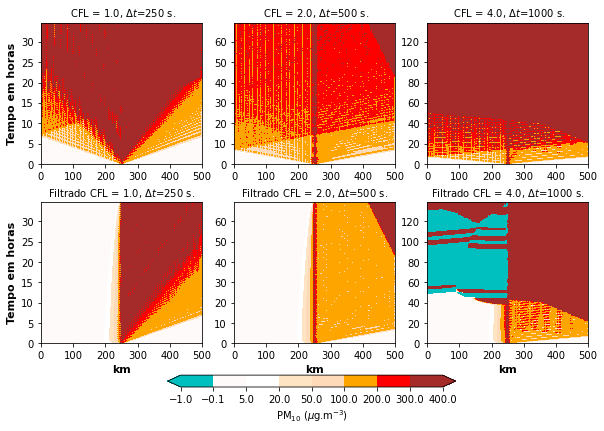

In [37]:
CFLs_6 = CFLs*2
deltas_6 = deltas*2
tempos = {}
for CFL, dt in zip(CFLs_6, deltas_6):
    tempos[CFL], X = np.meshgrid(np.linspace(0, (Nt-1)*dt, Nt), x)

Num = { 'CN1':C_cr1, 'CN2':C_cr2, 'CN4':C_cr4, 'CN1-f':C_cr1f, 'CN2-f':C_cr2f, 'CN4-f':C_cr4f,}
names = list(Num.keys())
names_2 = ['', '', '', 'Filtrado', 'Filtrado', 'Filtrado']


fig = plt.figure(figsize=[8,5.5], facecolor='w')
plt.subplots_adjust(bottom=0.15, top=0.96, left=0.04, right=0.99,
                    wspace=0.2, hspace=0.27) # horizontal & vertical spaces, respectively
nrows, ncols = 2, 3

for i in range(1, 7): 
    plt.subplot(nrows, ncols, i)
    im = plt.contourf(X/1000, tempos[CFLs_6[i-1]]/3600, Num[names[i-1]], levels, origin='lower', extend='both', colors=colores)
    plt.title(names_2[i-1]+f" CFL = {CFLs_6[i-1]}, $\Delta t$={deltas_6[i-1]} s.", fontsize=10)
    
    if i% ncols == 1: # Add ylabel for the very left subplots
        plt.ylabel('Tempo em horas', fontsize=11, fontweight='bold')
    if i > ncols*(nrows-1): # Add xlabel for the bottom row subplots
        plt.xlabel('km', fontsize=11, fontweight='bold')
        
# Add a colorbar at the bottom:
cax = fig.add_axes([0.26, 0.04, 0.5, 0.03])
cb = fig.colorbar(im, cax=cax, orientation="horizontal",shrink=1)
cb.ax.tick_params(labelsize=10)
cb.set_label(label=ylabel, color = 'k', size=10)
fig.savefig("fig/CN_CFLs.png", dpi=400, format='png', bbox_inches='tight', facecolor='w')

# Gifs
Crank-Nicolson

In [17]:
filenames = []
# plot the line chart
for n in range(0,Nt,2):
    fig, ax = plt.subplots(figsize=[12,4])
    ax.plot(x/1000, C_crf[:,n], color = 'peru', linestyle = 'solid', label="CN-f CFL=0.2")
    ax.plot(x/1000, C_cr1f[:,n], color = 'y', linestyle = 'solid', label="CN-f CFL=1")
    ax.plot(x/1000, C_cr2f[:,n], color = 'crimson', linestyle = 'dashed', label="CN-f CFL=2")
    ax.plot(x/1000, C_cr4f[:,n], color = 'purple', linestyle = 'solid', label="CN-f CFL=4")
    ax.set_ylim(-50,400)
    ax.set_title(f"N° passo tempo={n}.")
    ax.legend()
    ax.set_ylabel(ylabel)

    # create file name and append it to a list
    filename = f'fig/gifs/{n}.png'
    filenames.append(filename)

    # save frame
    fig.savefig(filename, dpi=300)
    plt.close() # build gif

with imageio.get_writer('gifs/CN_CFLs_filt_mitade.gif', mode='I', duration = .3) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
# Remove files
for filename in set(filenames):
    os.remove(filename)  

In [ ]:
# Não filtrado
# ------------
dt = 50
filenames = []
# plot the line chart
for n in range(0,Nt,2):
    fig, ax = plt.subplots(figsize=[12,4])
    ax.plot(x/1000, C_s[:,n], color = 'k', linestyle = 'solid', label="Analítico")
    ax.plot(x/1000, C[:,n], color = 'r', linestyle = 'solid', label="1a ordem")
    ax.plot(x/1000, C_l[:,n], color = 'g', linestyle = 'solid', label="Leapfrog 2")
    ax.plot(x/1000, C_4o[:,n], color = 'm', linestyle = 'solid', label="4a ordem")
    ax.plot(x/1000, C_cr[:,n], color = 'orange', linestyle = 'solid', label="CN")
    ax.set_ylim(-40,400)
    ax.set_title(f"tempo={round((n*dt/3600),1)} h, $\Delta t$ ={dt} s.")
    ax.legend()
    ax.set_ylabel(ylabel)

    # create file name and append it to a list
    filename = f'fig/gifs/{n}.png'
    filenames.append(filename)

    # save frame
    fig.savefig(filename, dpi=300)
    plt.close() # build gif

with imageio.get_writer('gifs/test_nf.gif', mode='I', duration = .15) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
# Remove files
for filename in set(filenames):
    os.remove(filename)  

In [ ]:
# Filtrado 
# --------
dt = 50
filenames = []
# plot the line chart
for n in range(0,Nt,2):
    fig, ax = plt.subplots(figsize=[12,4])
    ax.plot(x/1000, C_s[:,n], color = 'k', linestyle = 'solid', label="Analítico")
    ax.plot(x/1000, C[:,n], color = 'r', linestyle = 'solid', label="1a ordem")
    ax.plot(x/1000, C_lf[:,n], color = 'g', linestyle = 'solid', label="Leapfrog 2-f")
    ax.plot(x/1000, C_4of[:,n], color = 'm', linestyle = 'solid', label="4a ordem-f")
    ax.plot(x/1000, C_crf[:,n], color = 'orange', linestyle = 'solid', label="CN-f")
    ax.set_ylim(-40,400)
    ax.set_title(f"tempo={round((n*dt/3600),1)} h, $\Delta t$ ={dt} s.")
    ax.legend()
    ax.set_ylabel(ylabel)

    # create file name and append it to a list
    filename = f'fig/gifs/{n}.png'
    filenames.append(filename)

    # save frame
    fig.savefig(filename, dpi=300)
    plt.close() # build gif

with imageio.get_writer('gifs/test_f.gif', mode='I', duration = .15) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
# Remove files
for filename in set(filenames):
    os.remove(filename)  